In [91]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

Text(0.5, 0, 't')

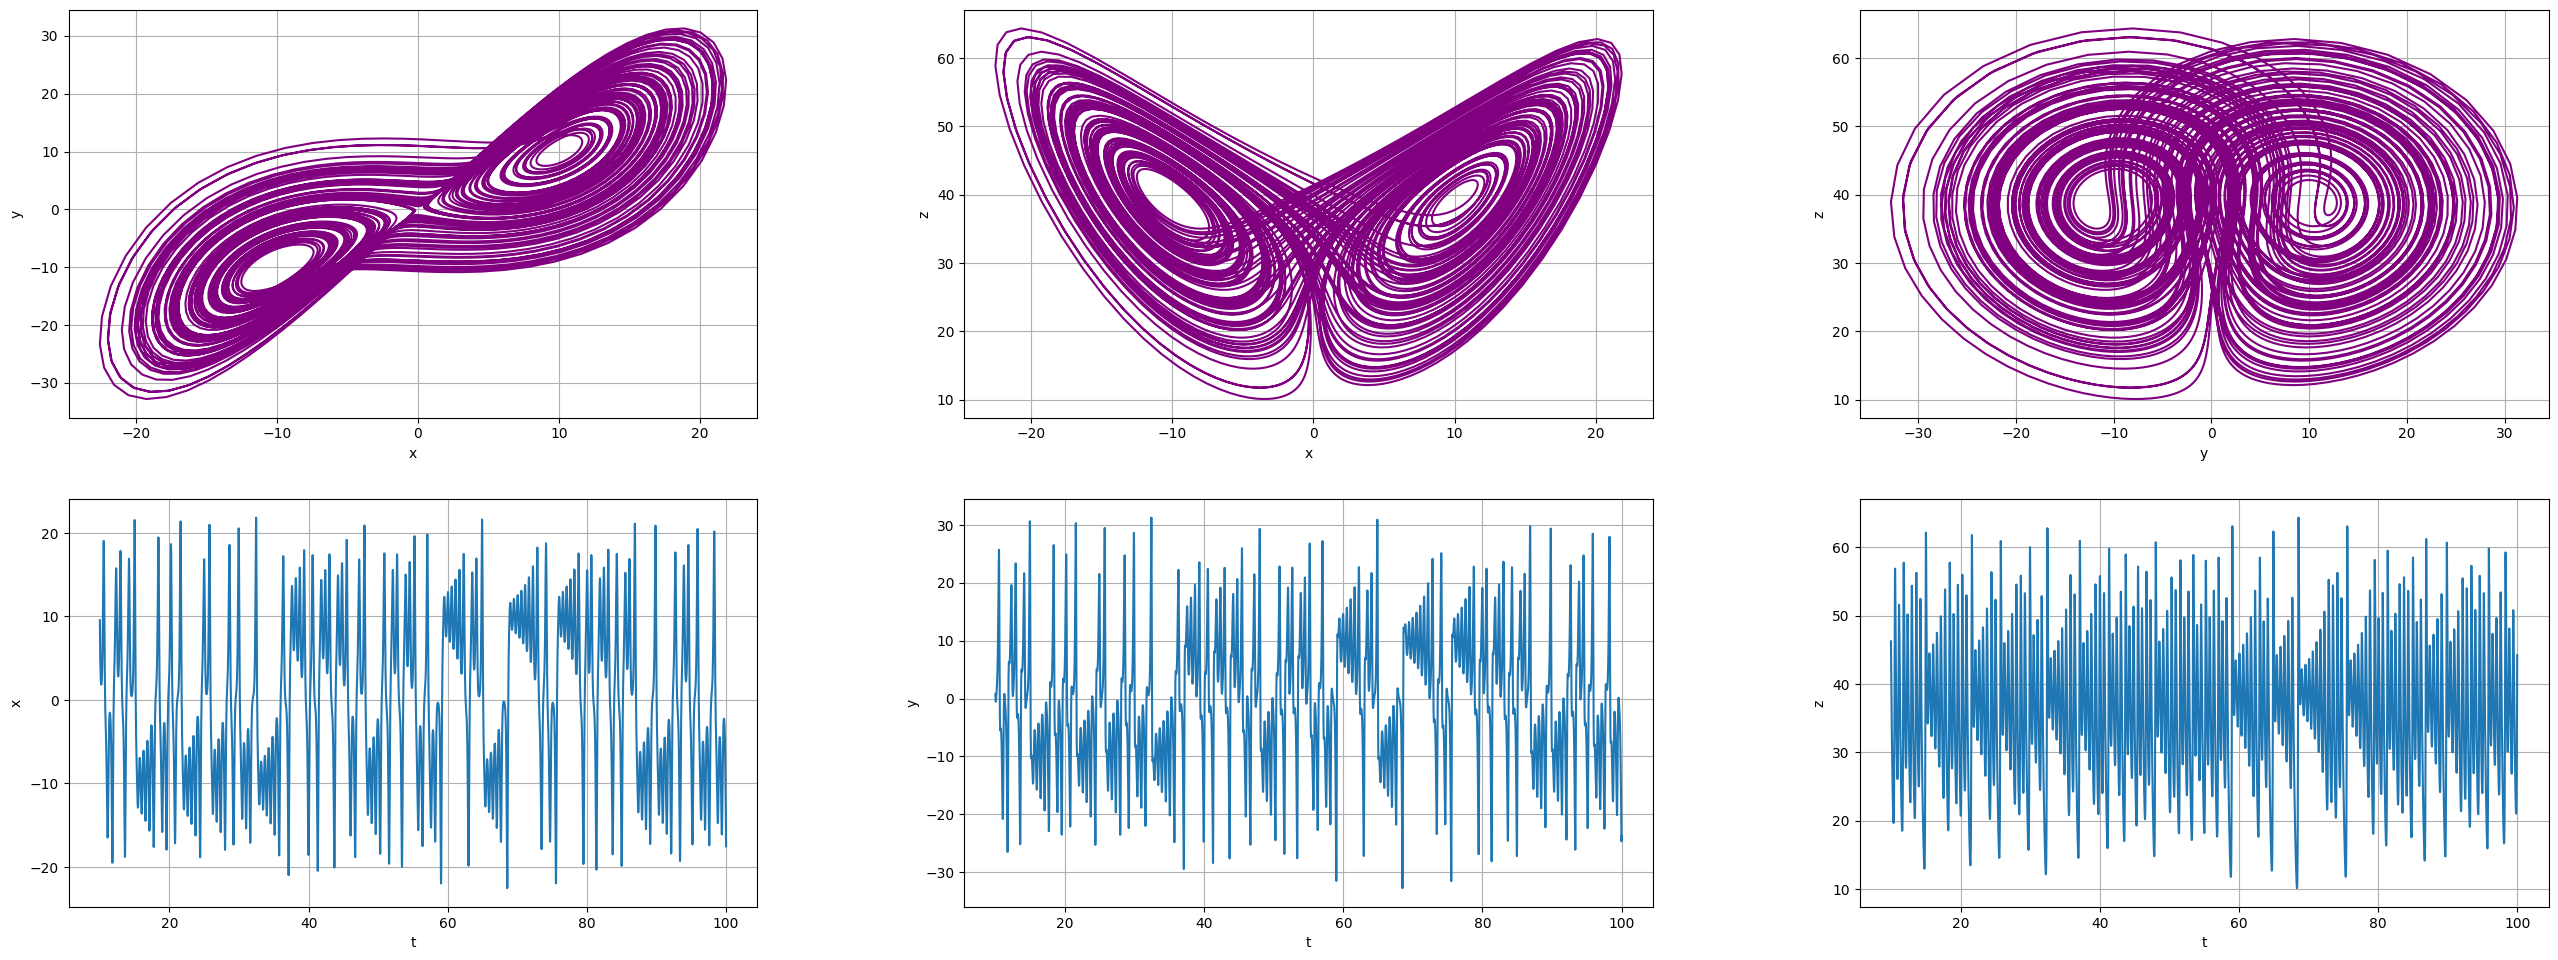

: 

In [92]:
#lorenz
%matplotlib inline
a = 10;
r1 = 40;
r2 = 35;
r3 = 35;
b = 8/3;
e = 10.6;

def lorenz(H, t):
    return np.array([a*(H[1]-H[0]), #x1 0
                    r1*H[0]-H[1]-H[0]*H[2], #y1 1
                    (-b*H[2]+H[0]*H[1]), #z1 2
                    a*(H[4]-H[3])+e*(H[0]-H[3]), #x2 3
                    r2*H[3]-H[4]-H[3]*H[5], #y2 4
                    (-b*H[5]+H[3]*H[4]), #z2 5
                    a*(H[7]-H[6])+e*(H[0]-H[6]), #x3 6
                    r3*H[6]-H[7]-H[6]*H[8], #y2 7
                    (-b*H[8]+H[6]*H[7])]) #z2 8
                    
                    

T = 10000; T0 = 1000;
t = np.linspace(0, 100, T)
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
H, infodict = integrate.odeint(lorenz, H0, t, full_output=True)
#H = integrate.solve_ivp(lorenz, t_span=[0,1000], y0=H0, method="RK45", max_step=0.01, atol = 1, rtol = 1)

plt.figure(num=None, figsize=((32,18)), dpi= 100)
plt.subplots_adjust(wspace = 0.3)

plt.subplot(3,3,1)
plt.grid()
plt.plot(H[T0:,0], H[T0:,1],c='purple')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(3,3,4)
plt.plot(t[T0:,],H[T0:,0])
plt.grid()
plt.ylabel('x')
plt.xlabel('t')

plt.subplot(3,3,2)
plt.plot(H[T0:,0], H[T0:,2],c='purple')
plt.grid()
plt.ylabel('z')
plt.xlabel('x')

plt.subplot(3,3,5)
plt.plot(t[T0:,],H[T0:,1])
plt.grid()
plt.ylabel('y')
plt.xlabel('t')

plt.subplot(3,3,3)
plt.plot(H[T0:,1], H[T0:,2],c='purple')
plt.grid()
plt.ylabel('z')
plt.xlabel('y')

plt.subplot(3,3,6)
plt.plot(t[T0:,],H[T0:,2])
plt.grid()
plt.ylabel('z')
plt.xlabel('t')




In [63]:
import pathlib
data_dir = pathlib.Path('C:\\Users\\icosane\\Desktop\\New folder\\lorenz').with_suffix('')

In [64]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1260


In [65]:
xy = list(data_dir.glob('xy/*'))
#PIL.Image.open(str(xy[0]))

In [66]:
batch_size = 32
img_height = 554
img_width = 413

In [67]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1260 files belonging to 3 classes.
Using 1008 files for training.


In [68]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1260 files belonging to 3 classes.
Using 252 files for validation.


In [69]:
class_names = train_ds.class_names
print(class_names)

['xy', 'zx', 'zy']


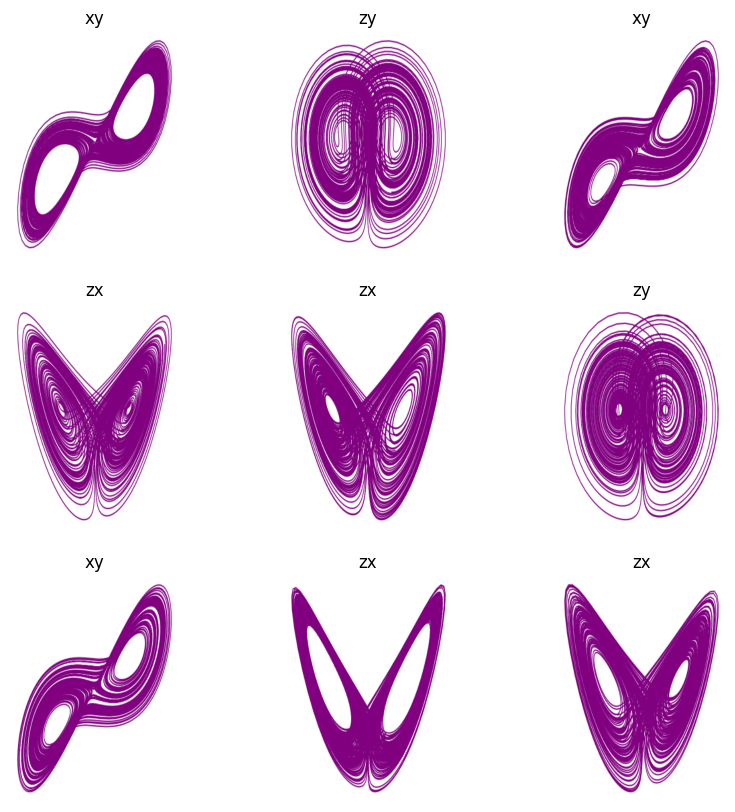

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [71]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [72]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [74]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [75]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [78]:
len(train_ds)//batch_size

1

In [79]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/5


32/32 [==============================] - 83s 3s/step - loss: 0.6676 - accuracy: 0.8958 - val_loss: 1.9235e-05 - val_accuracy: 1.0000
Epoch 2/5
32/32 [==============================] - 84s 3s/step - loss: 8.4388e-07 - accuracy: 1.0000 - val_loss: 8.3438e-07 - val_accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 84s 3s/step - loss: 2.3180e-08 - accuracy: 1.0000 - val_loss: 7.2465e-07 - val_accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 83s 3s/step - loss: 1.8922e-08 - accuracy: 1.0000 - val_loss: 6.6317e-07 - val_accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 83s 3s/step - loss: 1.7030e-08 - accuracy: 1.0000 - val_loss: 6.0357e-07 - val_accuracy: 1.0000


In [80]:
model.evaluate(val_ds)

8/8 [==============================] - 3s 431ms/step - loss: 6.0357e-07 - accuracy: 1.0000


[6.035716637597943e-07, 1.0]

In [81]:
model.save("C:\\Users\\icosane\\Desktop\\New folder\\lorenz\\_model.h5")

c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
for test_images, test_labels in val_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape
predictions[1]
np.argmax(predictions[0])
test_labels[1]

1/1 [==============================] - 0s 449ms/step


0

In [88]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array = predictions_array[i]
  true_label = true_labels[i] 
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array = predictions_array[i]
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

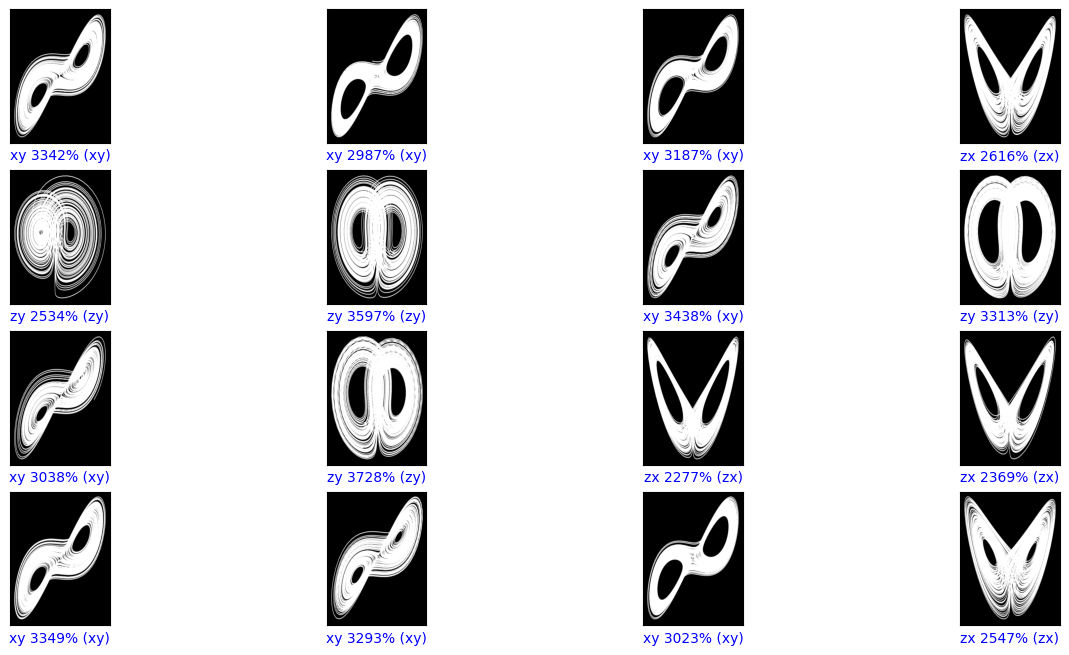

In [90]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_rows, 2*num_cols))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)